In [45]:
# -*- coding: utf-8 -*-
"""
Created on Thu Nov  4 19:02:01 2021

@author: Administrator
"""

from scipy.io import arff
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC,SVR
from sklearn.tree import DecisionTreeClassifier
import sklearn.preprocessing as skpre
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix
from functools import reduce
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_wine
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import  make_scorer
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
warnings.filterwarnings('ignore')

In [47]:
######Functions used

#change yields data to state or trading operation
def Dummy(yields,a=.02,b=-.02):   
    dummy=[]
    for i in range(len(yields)):
        if float(yields.iloc[i])>=a:
            dummy.append(1)
        elif float(yields.iloc[i])<b:
            dummy.append(-1)
        else:
            dummy.append(0)
    output=pd.DataFrame(dummy)
    return output

def my_metrics(C):   #output rates
    print('TrueShortRate=',C[0][0]/C[0].sum())
    print('FalseShortRate=',C[0][2]/C[0].sum())
    print('CaughtShortRate=',C[0][0]/C.iloc[0,:].sum())
    print('TrueLongRate=',C[2][2]/C[2].sum())
    print('FalseLongRate=',C[2][0]/C[2].sum())
    print('CaughtLongRate=',C[2][2]/C.iloc[2,:].sum())

def add(x,y):
    return(1+x)*(1+y)
#output yileds data
def yields(predict,returns): 
    real=returns.iloc[-len(predict):]
    if len(predict)==len(real):
        yields=[]
        for i in range(len(predict)):
            if int(predict.iloc[i])==1:
                yields.append(real.iloc[i]) 
            elif int(predict.iloc[i])==-1:
                yields.append(-real.iloc[i])
            else:
                yields.append(0)
#        accy=pd.DataFrame(reduce(add,yields))
            for i in range(len(yields)):
                if yields[i]<=-1:
                    return '爆仓'
                    
        yields=pd.DataFrame(yields)    
        return yields
        pring('wrong input')
#ouput accumulated yields        
def accy(yields)  : 
    if type(yields)==str:
        return '爆仓'
    else:
        accy=[]
        for i in range(len(yields)):
                if i==0:
                    accy.append(1+yields.iloc[0])
                else:
                    accy.append((accy[i-1])*(1+yields.iloc[i]))
        return pd.DataFrame(accy)
#output the score defined by myself
def my_score(estimator,X_train,y_train,X_test,y_test):    
    model=estimator.fit(X_train,y_train)
    C=pd.DataFrame(confusion_matrix(y_test,pd.DataFrame(estimator.predict(X_test)) ,labels=[-1,0,1])) 
    if C[0].sum()!=0:
        TrueShortRate=C[0][0]/C[0].sum()
        FalseShortRate=C[0][2]/C[0].sum()
        CaughtShortRate=C[0][0]/C.iloc[0,:].sum()
    else:
        return -10000
    if C[2].sum()!=0:
        TrueLongRate=C[2][2]/C[2].sum()
        FalseLongRate=C[2][0]/C[2].sum()
        CaughtLongRate=C[2][2]/C.iloc[2,:].sum()
    else:
        return -10000
    if TrueShortRate-FalseShortRate<0 and TrueLongRate-FalseLongRate<0:
        return -10000
    score=(TrueShortRate-FalseShortRate)*(TrueLongRate-FalseLongRate)
    return score

In [3]:
#output the score after sliding window crossvaliadation
#During this function, we redo the features selection and standarlization in different splits

def sliding_window_score(train_size,test_size,scoring,X,y,estimator,sliding_size):
    score=[]
    spilts=[]
    if len(X)==len(y):
        for i in range(0,len(X),sliding_size):
            if i<=len(X)-train_size-test_size:
                if len(X)-train_size-i-sliding_size<=test_size:
                    scaler = skpre.StandardScaler()
                    X_train=X.iloc[i:-test_size,:]
                    X_test=X.iloc[-test_size:,:]
                    y_train=y.iloc[i:-test_size,:]
                    y_test=y.iloc[-test_size:,:]
                    OX_train_std = scaler.fit_transform(X_train)
                    OX_test_std = scaler.transform(X_test)
                    y_train=y_train*1
                    y_test=y_test*1
                    y_train=y_train.astype(int)
                    y_test=y_test.astype(int)  
                    
                    lables=Input.columns[:]
                    forest = RandomForestClassifier(n_estimators=50,random_state=1)
                    forest.fit(OX_train_std, y_train)
                    importances = forest.feature_importances_
                    indices = np.argsort(importances)[::-1]
                    new = SelectFromModel(forest, threshold=0.01,prefit=True)
                    X_train_std = pd.DataFrame(new.transform(OX_train_std))
                    X_test_std   =pd.DataFrame(new.transform(OX_test_std))
                    
                    score.append(scoring(estimator=estimator,X_train=X_train_std,
                                         X_test=X_test_std,
                                         y_train=y_train,
                                         y_test=y_test))
                    spilts.append(i)
                    spilts.append(len(X)-test_size)
                    spilts.append(len(X))
                else:
                    scaler = skpre.StandardScaler()
                    X_train=X.iloc[i:i+train_size,:]
                    X_test=X.iloc[i+train_size:i+train_size+test_size,:]
                    y_train=y.iloc[i:i+train_size,:]
                    y_test=y.iloc[i+train_size:i+train_size+test_size,:]
                    OX_train_std = scaler.fit_transform(X_train)
                    OX_test_std = scaler.transform(X_test)
                    y_train=y_train*1
                    y_test=y_test*1
                    y_train=y_train.astype(int)
                    y_test=y_test.astype(int)  
                    
                    lables=Input.columns[:]
                    forest = RandomForestClassifier(n_estimators=50,random_state=1)
                    forest.fit(OX_train_std, y_train)
                    importances = forest.feature_importances_
                    indices = np.argsort(importances)[::-1]
                    new = SelectFromModel(forest, threshold=0.01,prefit=True)
                    X_train_std = pd.DataFrame(new.transform(OX_train_std))
                    X_test_std   =pd.DataFrame(new.transform(OX_test_std))
                    
                    score.append(scoring(estimator=estimator,X_train=X_train_std,
                                         X_test=X_test_std,
                                         y_train=y_train,
                                         y_test=y_test))
                    spilts.append(i)
                    spilts.append(i+train_size)
                    spilts.append(i+train_size+test_size)
       
        return pd.DataFrame(score)

        

In [4]:
# Output Sharpe ratio

def Sharpe(estimator,X_train,y_train,X_test,y_test):    
    model=estimator.fit(X_train,y_train)
    model_pre=pd.DataFrame(model.predict(X_test)) #
    y_y=y_test.reset_index(drop=1)
    model_confusion=pd.DataFrame(confusion_matrix(y_y,model_pre,labels=[-1,0,1]))
    y=yields(model_pre,price.iloc[:,1]) 
    return y.mean(axis=0)/y.std(axis=0)

In [5]:
# Read data

weekdata=pd.read_excel(r"D:\Enter\学习资料\Machine Learning in Finance\Project\weekly data-EN.xlsx",sheet_name='Sheet1')
weekdata=weekdata.iloc[:,1:].interpolate()  #Fill NaN

Input1=weekdata.pct_change().drop(index=[0,len(weekdata)-1]).reset_index(drop=1)      
Input2=weekdata.drop(index=[0,len(weekdata)-1]).reset_index(drop=1)   
Input=Input1.join(Input2,lsuffix='_pct').drop(columns=['PPI_I_yoy_pct','PPI_I_mom_pct'])
price=pd.read_excel(r"D:\Enter\学习资料\Machine Learning in Finance\Project\yields.xlsx",sheet_name='Sheet1').drop('Time',axis=1).drop(index=[0,1]).reset_index(drop=1)  
y=Dummy(price.iloc[:,1])
yr=pd.DataFrame(price.iloc[:,1])
print("Is Input there any NaN?",Input.isnull().values.any()) 

#Split Training and Test

X_train=Input.iloc[0:int(0.8*len(Input)),:]
X_test=Input.iloc[int(0.8*len(Input)):,:]
y_train=y.iloc[0:int(0.8*len(y)),:]
y_test=y.iloc[int(0.8*len(y)):,:]
yr_train=yr.iloc[0:int(0.8*len(y)),:]
yr_test=yr.iloc[int(0.8*len(y)):,:]
#X_train, X_test, y_train, y_test =\
#    train_test_split(Input, y, test_size=0.2, random_state=0, stratify=None)
tscv = TimeSeriesSplit(n_splits=5,max_train_size=100)
Input.head()

Is Input there any NaN? False


,Inv_Steel_pct,Inv_Iron_pct,GP_Rebar_pct,Cost_Rebar_pct,SP_Rebar_pct,SP_Iron_pct,FP_FS_pct,FB_Mn-Si_pct,FB_Coke_pct,SP_Coke_pct,...,M2,PPI,CA_REDI,CA_FAI,HCA,CSA,CHSA,PPI_I_yoy,PPI_I_mom,FP_Rebar.1
0,0.024660,0.004041,0.102218,0.038983,0.007880,0.003738,-0.018208,-0.010855,-0.193654,-0.000485,...,1519485.40,0.83,9377.0233,57522.5767,14951.9293,1.3,15153.7476,1.2,0.7,3039.0
1,0.006727,0.004293,0.035225,0.039732,0.063727,0.026071,-0.001455,-0.010507,0.020255,-0.005820,...,1530432.06,2.22,9412.4679,54118.9623,14140.9447,-0.5,15491.2065,3.3,1.5,3198.0
2,0.016677,-0.012378,-0.038519,0.079217,0.035875,-0.005445,-0.008012,-0.110665,-0.007657,-0.018537,...,1530432.06,2.22,9412.4679,54118.9623,14140.9447,-0.5,15491.2065,3.3,1.5,3251.0
3,0.029112,0.024795,-0.120141,-0.018459,0.034632,-0.034672,-0.031938,-0.011674,-0.059160,-0.014911,...,1530432.06,2.22,9412.4679,54118.9623,14140.9447,-0.5,15491.2065,3.3,1.5,3088.0
4,0.035524,0.000000,-0.398391,0.036036,-0.058050,-0.003781,-0.032992,-0.089933,-0.077764,-0.016145,...,1530432.06,2.22,9412.4679,54118.9623,14140.9447,-0.5,15491.2065,3.3,1.5,2923.0


In [6]:
y.head  #y means that we use states as output

<bound method NDFrame.head of      0
0    1
1    0
2   -1
3   -1
4    0
..  ..
248  0
249  0
250  0
251 -1
252 -1

[253 rows x 1 columns]>

In [7]:
yr.head() #yr means that we use return as the output

,Return
0,0.052320
1,0.016573
2,-0.050138
3,-0.053433
4,0.012658


In [8]:
#Standardlized
scaler = skpre.StandardScaler()
OX_train_std = scaler.fit_transform(X_train)
OX_test_std = scaler.transform(X_test)
y_train=y_train*1
y_test=y_test*1
y_train=y_train.astype(int)
y_test=y_test.astype(int)    

<Figure size 432x288 with 0 Axes>

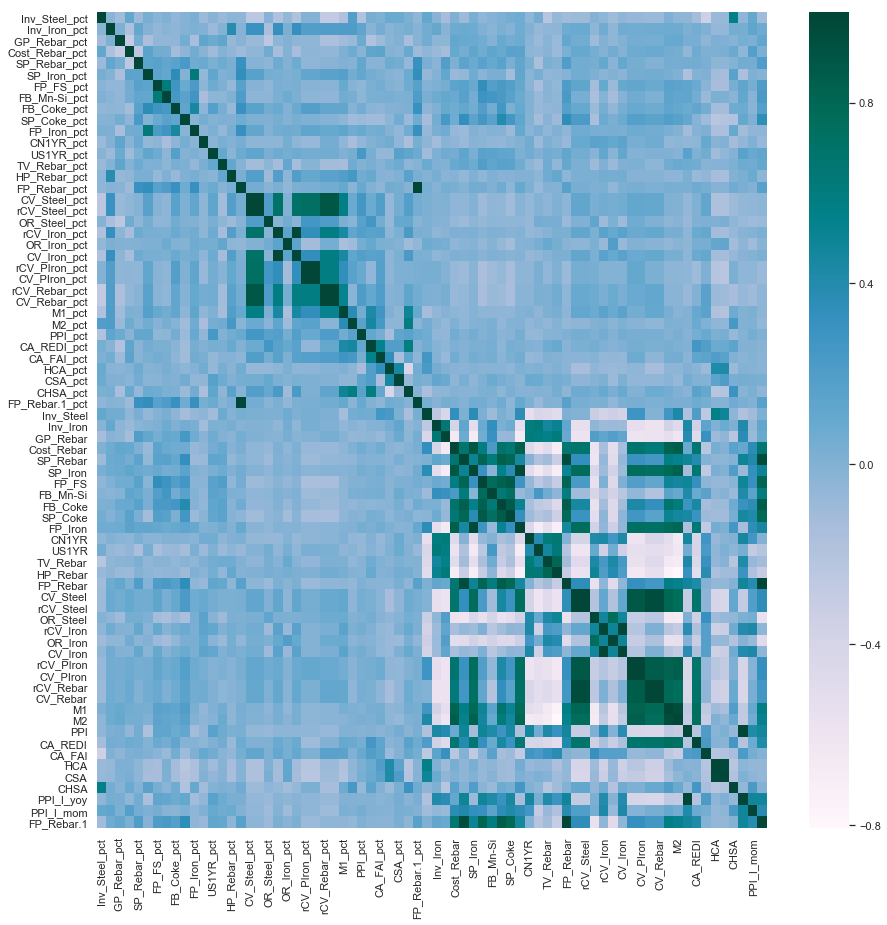

In [29]:
#Corelation matrix of Input
sns.set()
cor_matrix=Input.corr()
cor_matrix

fig=plt.figure()
f, ax = plt.subplots(figsize=(15, 15))
sns_plot_cor1=sns.heatmap(cor_matrix,ax=ax,cmap='PuBuGn')


In [39]:
#Select Features（return as output）

lables=Input.columns[:]
r_forest = RandomForestRegressor(n_estimators=50,random_state=1)
r_forest.fit(OX_train_std, yr_train)
r_importances = r_forest.feature_importances_
r_indices = np.argsort(r_importances)[::-1]
for f in range(OX_train_std.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,lables[r_indices[f]],r_importances[r_indices[f]]))
r_new = SelectFromModel(r_forest, threshold=0.025,prefit=True)
Xr_train_std = pd.DataFrame(r_new.transform(OX_train_std))
Xr_test_std   =pd.DataFrame(r_new.transform(OX_test_std))

 1) FP_Rebar_pct                   0.049638
 2) FP_Rebar.1_pct                 0.048865
 3) SP_Rebar_pct                   0.042124
 4) SP_Coke                        0.041513
 5) CSA_pct                        0.035630
 6) FP_Rebar                       0.031358
 7) Inv_Steel                      0.030029
 8) FP_FS                          0.029767
 9) FP_Rebar.1                     0.029093
10)  GP_Rebar_pct                  0.027382
11) Inv_Steel_pct                  0.027270
12) TV_Rebar_pct                   0.026185
13) SP_Iron_pct                    0.025811
14) US1YR_pct                      0.025766
15) Cost_Rebar                     0.022208
16) FB_Mn-Si_pct                   0.020878
17) FB_Coke                        0.020647
18) CN1YR_pct                      0.019508
19) FP_Iron_pct                    0.019303
20)  GP_Rebar                      0.018224
21) CA_FAI                         0.018210
22) HP_Rebar_pct                   0.017649
23) FP_FS_pct                   

<Figure size 432x288 with 0 Axes>

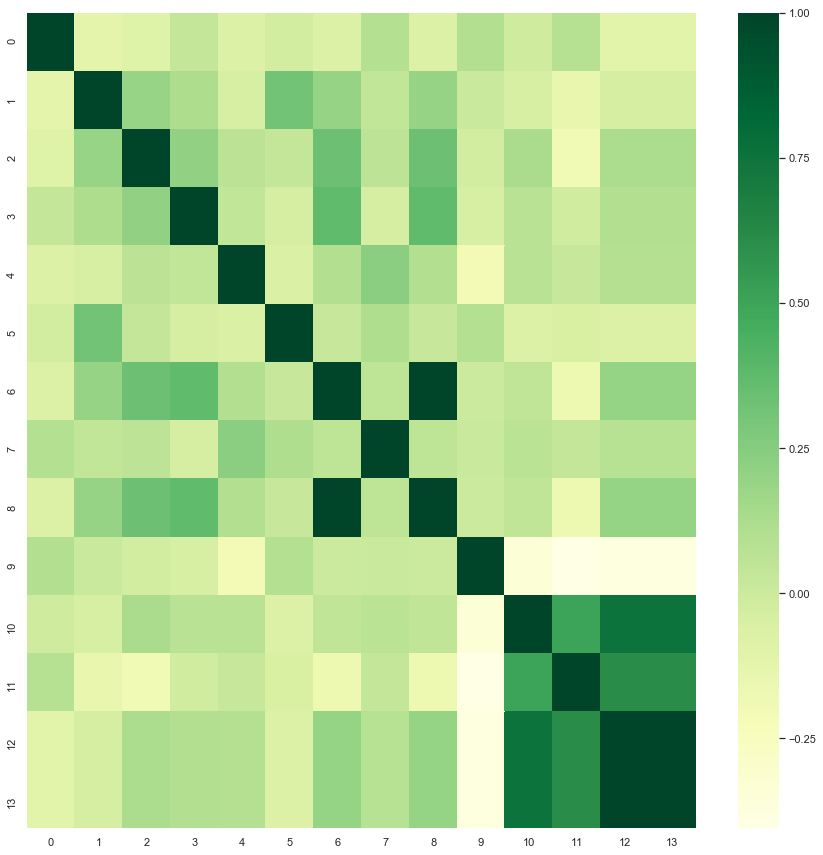

In [40]:
#Corelation matrix of Xr after features selection

sns.set()
cor1=Xr_train_std.corr()
fig=plt.figure()

f, ax = plt.subplots(figsize=(15, 15))

sns_plot_cor1=sns.heatmap(cor1,ax=ax,cmap='YlGn')
plt.show()

In [11]:
#Select features(states as output)
lables=Input.columns[:]
forest = RandomForestClassifier(n_estimators=50,random_state=1)
forest.fit(OX_train_std, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(OX_train_std.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,lables[indices[f]],importances[indices[f]]))
new = SelectFromModel(forest, threshold=0.01,prefit=True)
X_train_std = pd.DataFrame(new.transform(OX_train_std))
X_test_std   =pd.DataFrame(new.transform(OX_test_std))

 1) SP_Rebar_pct                   0.038267
 2) Inv_Steel_pct                  0.033634
 3) FP_Rebar.1                     0.027421
 4) CN1YR_pct                      0.026681
 5) FB_Mn-Si_pct                   0.025906
 6) TV_Rebar_pct                   0.025661
 7)  GP_Rebar_pct                  0.023991
 8) SP_Coke                        0.022906
 9) FB_Coke_pct                    0.022774
10) FP_Rebar.1_pct                 0.021769
11) HP_Rebar_pct                   0.021163
12) FP_Iron_pct                    0.021154
13) FP_Rebar                       0.020406
14) US1YR_pct                      0.019332
15) FP_Rebar_pct                   0.019192
16) SP_Iron_pct                    0.019115
17) Cost_Rebar_pct                 0.019081
18) FB_Coke                        0.018385
19) Cost_Rebar                     0.018275
20) HP_Rebar                       0.017723
21) Inv_Iron_pct                   0.017626
22) SP_Coke_pct                    0.017531
23) FP_Iron                     

<Figure size 432x288 with 0 Axes>

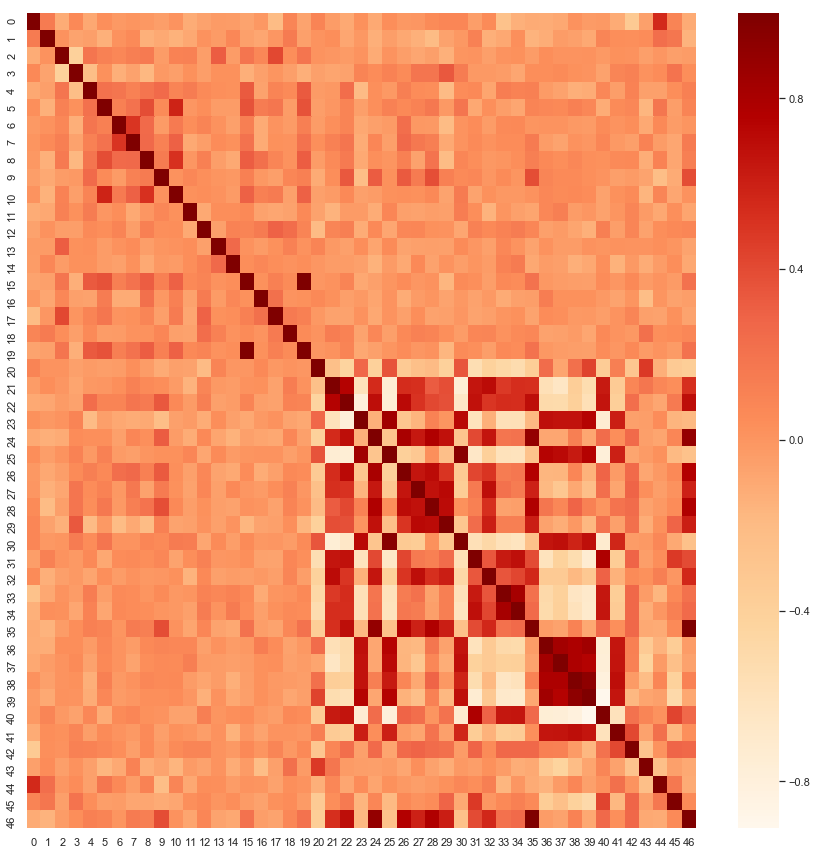

In [36]:
#Corelation matrix of X after features selection

sns.set()
cor2=X_train_std.corr()
fig=plt.figure()

f, ax = plt.subplots(figsize=(15, 15))

sns_plot_cor1=sns.heatmap(cor2,ax=ax,cmap='OrRd')
plt.show()

In [49]:
#All models below(including cls and reg) are using greedy search to optimize
#Try states output first
#LR model with crossvalidation

Para_lr_C=[x/10 for x in range(1,100)]
lrT_score=-10  #暂时储存score
lrT_C=0
for lrC in Para_lr_C:
    lr= LogisticRegression(penalty='l2',
                       solver = 'lbfgs',C=lrC,class_weight={0:0.2, 1:0.4,-1:0.4},multi_class='multinomial'
                       )
    b=float(sliding_window_score(100,30,Sharpe,Input,y,lr,30).mean(axis=0))
    if lrT_score<b:
        lrT_score=b
        lrT_C=lrC

lr= LogisticRegression(penalty='l2',
                       solver = 'lbfgs',C=lrT_C,class_weight={0:0.2, 1:0.4,-1:0.4},multi_class='multinomial'
                       )
lr.fit(X_train_std, y_train)
lr_pre=pd.DataFrame(lr.predict(X_test_std)) #LR模型预测的交易信号
y_y=y_test.reset_index(drop=1)
lr_confusion_m=pd.DataFrame(confusion_matrix(y_y,lr_pre,labels=[-1,0,1])) #LR的混淆矩阵
lr_yields=yields(lr_pre,price.iloc[:,1]) #LR模型的单次收益率
lr_accy=accy(lr_yields)
my_metrics(lr_confusion_m)      
      
  
print('LR best score',lrT_score)
print('LR best para C=',lrT_C)
print('LR return',lr_accy.iloc[-1,0]-1)


TrueShortRate= 0.2222222222222222
FalseShortRate= 0.2222222222222222
CaughtShortRate= 0.2
TrueLongRate= nan
FalseLongRate= nan
CaughtLongRate= 0.0
LR best score 0.0025547295864123353
LR best para C= 0.2
LR return 0.126534799426832


In [51]:
#SVM classifier model with crossvalidation

Para_SVM_C=[x/10 for x in range(1,200,2)]
Para_SVM_gamma=[x/100 for x in range(1,2)]
SVMT_score=-1  #暂时储存score
SVMT_C=0
for SVMC in Para_SVM_C:
    for SVMgamma in Para_SVM_gamma:
        SVM=SVC(kernel='rbf', random_state=0, C=SVMC, gamma=SVMgamma,decision_function_shape='ovr') 
      
        SVM_score=float(sliding_window_score(100,30,Sharpe,Input,y,SVM,30).mean(axis=0))
        if SVMT_score<SVM_score:
            SVMT_score=SVM_score
            SVMT_C=SVMC
            SVMT_gamma=SVMgamma
SVM=SVC(kernel='rbf', random_state=0, C=SVMT_C, gamma=SVMgamma,decision_function_shape='ovr') 
SVM.fit(X_train_std, y_train)
SVM_pre=pd.DataFrame(SVM.predict(X_test_std)) #SVM模型预测的交易信号
y_y=y_test.reset_index(drop=1)
SVM_confusion=pd.DataFrame(confusion_matrix(y_y,SVM_pre,labels=[-1,0,1])) #SVM的混淆矩阵
SVM_yields=yields(SVM_pre,price.iloc[:,1]) #SVM模型的单次收益率
SVM_accy=accy(SVM_yields)
my_metrics(SVM_confusion)      

print('SVM best score',SVMT_score)
print('SVM best para C=',SVMT_C)
print('SVM best para gamma=',SVMT_gamma)
print('SVM return',SVM_accy.iloc[-1,0]-1)


TrueShortRate= nan
FalseShortRate= nan
CaughtShortRate= 0.0
TrueLongRate= nan
FalseLongRate= nan
CaughtLongRate= 0.0
SVM best score 0.019878841561540947
SVM best para C= 1.1
SVM best para gamma= 0.01
SVM return 0


In [55]:
# DecisionTree  classifier model with crossvalidation
Para_tree_depth=[x for x in range(1,47)]
treeT_score=-1  #暂时储存score
treeT_depth=0
for treedepth in Para_tree_depth:
    tree = DecisionTreeClassifier(criterion='gini',max_depth=treedepth)
    tree.fit(X_train_std, y_train)
    tree_score=float(sliding_window_score(100,30,Sharpe,Input,y,tree,30).mean(axis=0))
    if treeT_score<tree_score:
        treeT_score=tree_score
        treeT_depth=treedepth
tree=DecisionTreeClassifier(criterion='gini',max_depth=treedepth)
tree.fit(X_train_std, y_train)
tree_pre=pd.DataFrame(tree.predict(X_test_std)) #tree模型预测的交易信号
y_y=y_test.reset_index(drop=1)
tree_confusion=pd.DataFrame(confusion_matrix(y_y,tree_pre,labels=[-1,0,1])) #tree的混淆矩阵
tree_yields=yields(tree_pre,price.iloc[:,1]) #tree模型的单次收益率
tree_accy=accy(tree_yields)
my_metrics(tree_confusion)      

print('tree best score',treeT_score)
print('tree best para depth=',treeT_depth)
print('tree return',tree_accy.iloc[-1,0]-1)


TrueShortRate= 0.14285714285714285
FalseShortRate= 0.3333333333333333
CaughtShortRate= 0.3
TrueLongRate= 0.25
FalseLongRate= 0.3125
CaughtLongRate= 0.2222222222222222
tree best score 0.12344237294899704
tree best para depth= 33
tree return -0.29554342602929295


In [56]:
#Random forest classifier model with crossvalidation


Para_RF_n=[x for x in range(1,100)]
RFT_score=-1  #暂时储存score
RFT_n=0
for RFn in Para_RF_n:
    RF = RandomForestClassifier(n_estimators=RFn,random_state=0, oob_score=1,criterion='gini',max_depth=22)
    RF.fit(X_train_std, y_train)
    RF_score=float(sliding_window_score(100,30,Sharpe,Input,y,RF,30).mean(axis=0))
    if RFT_score<RF_score:
        RFT_score=RF_score
        RFT_n=RFn
RF=RandomForestClassifier(n_estimators=RFn,random_state=0, oob_score=1,criterion='gini')
RF.fit(X_train_std, y_train)
RF_pre=pd.DataFrame(RF.predict(X_test_std)) #tree模型预测的交易信号
y_y=y_test.reset_index(drop=1)
RF_confusion=pd.DataFrame(confusion_matrix(y_y,RF_pre,labels=[-1,0,1])) #RF的混淆矩阵
RF_yields=yields(RF_pre,price.iloc[:,1]) #RF模型的单次收益率
RF_accy=accy(RF_yields)
my_metrics(RF_confusion)      
     

print('RF best score',RFT_score)
print('RF best para n_estimators=',RFT_n)
print('RF return',RF_accy.iloc[-1,0]-1)


TrueShortRate= 0.25
FalseShortRate= 0.0
CaughtShortRate= 0.1
TrueLongRate= nan
FalseLongRate= nan
CaughtLongRate= 0.0
RF best score 0.22371394330340352
RF best para n_estimators= 10
RF return 0.07937434899425755


In [65]:
#Gradient Boosting Decision Tree classifier model with cross validation

Para_gbdt_n=[x for x in range(20,100)]
Para_gbdt_l=[x/10 for x in range(1,10)]
gbdtT_score=-1 
gbdtT_n=0
gbdtT_l=0
for gbdtn in Para_gbdt_n:
    for gbdtl in Para_gbdt_l:
        gbdt=GradientBoostingClassifier(n_estimators=gbdtn,learning_rate=gbdtl)
        gbdt.fit(X_train_std, y_train)
        gbdt_score=my_score(gbdt,X_train_std,y_train,X_test_std,y_test)
        if gbdtT_score<gbdt_score:
            gbdtT_score=gbdt_score
            gbdtT_n=gbdtn
            gbdtT_l=gbdtl
gbdt=GradientBoostingClassifier(n_estimators=gbdtT_n,learning_rate=gbdtT_l)
gbdt.fit(X_train_std, y_train)
gbdt_pre=pd.DataFrame(gbdt.predict(X_test_std))
y_y=y_test.reset_index(drop=1)
gbdt_confusion=pd.DataFrame(confusion_matrix(y_y,gbdt_pre,labels=[-1,0,1]))
gbdt_yields=yields(gbdt_pre,price.iloc[:,1]) 
gbdt_accy=accy(gbdt_yields)
my_metrics(gbdt_confusion)      

print('gbdt best score',gbdtT_score)
print('gbdt best para n=',gbdtT_n)
print('gbdt best para learning rate=',gbdtT_l)
print('gbdt return',gbdt_accy.iloc[-1,0]-1)



TrueShortRate= 0.21739130434782608
FalseShortRate= 0.2608695652173913
CaughtShortRate= 0.5
TrueLongRate= 0.4
FalseLongRate= 0.4
CaughtLongRate= 0.1111111111111111
gbdt best score 0.04166666666666667
gbdt best para n= 23
gbdt best para learning rate= 0.5
gbdt return -0.12052389327108748


In [57]:
#After the states output, we try regression models using return as output
#Linear Regression

from sklearn.linear_model import LinearRegression

linear=LinearRegression()
linear.fit(Xr_train_std,yr_train)
linear_pre=pd.DataFrame(linear.predict(Xr_test_std)) 
linear_operation=Dummy(linear_pre,a=0.02,b=-0.02)

linear_yields=yields(linear_operation,price.iloc[:,1])
linear_accy=accy(linear_yields)
linear_confusion=pd.DataFrame(confusion_matrix(y_y,linear_operation,labels=[-1,0,1]))
my_metrics(linear_confusion)  
print('linear return',linear_accy.iloc[-1,0]-1)
print('linear R^2',linear.score(Xr_test_std,yr_test))


TrueShortRate= 0.2
FalseShortRate= 0.35
CaughtShortRate= 0.4
TrueLongRate= 0.0
FalseLongRate= 0.375
CaughtLongRate= 0.0
linear return -0.21836924807167202
linear R^2 -2.2267638637932823


In [58]:
#Supporting Vector Regression model with cross validation

from sklearn.svm import SVC,SVR
SVReg= SVR(kernel='rbf',C=0.1,gamma=0.01)
SVReg.fit(Xr_train_std, yr_train)

SVR_param_grid={'C': [x/10 for x in range(1,100)],'gamma':[x/100 for x in range(1,100)]}
gridSVR = GridSearchCV(SVReg.fit(Xr_train_std, yr_train),SVR_param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
gsSVR=gridSVR.fit(Xr_test_std, yr_test) 
gsSVR_pre=pd.DataFrame(gsSVR.predict(Xr_test_std))
gsSVR_op=Dummy(gsSVR_pre)
gsSVR_yields=yields(gsSVR_op,price.iloc[:,1])
gsSVR_accy=accy(gsSVR_yields)
gsSVR_confusion=pd.DataFrame(confusion_matrix(y_y,gsSVR_op,labels=[-1,0,1]))
my_metrics(gsSVR_confusion)  
print('SVR return',gsSVR_accy.iloc[-1,0]-1)
print('SVR MSE',gsSVR.best_score_)


TrueShortRate= 1.0
FalseShortRate= 0.0
CaughtShortRate= 0.1
TrueLongRate= 0.25
FalseLongRate= 0.125
CaughtLongRate= 0.1111111111111111
SVR return 0.24700281379267763
SVR MSE -0.0020453650511078917


In [60]:
# Decision Tree Regression model with cross validation

from sklearn.tree import DecisionTreeRegressor
treeReg=DecisionTreeRegressor(max_depth=10)
treeReg.fit(Xr_train_std,yr_train)
treeReg_para_grid={'max_depth':[x for x in range(1,20)]}
gridtreeReg=GridSearchCV(treeReg.fit(Xr_train_std,yr_train),treeReg_para_grid,cv=tscv)
gstreeReg=gridtreeReg.fit(Xr_test_std, yr_test) 
gstreeReg_pre=pd.DataFrame(gstreeReg.predict(Xr_test_std))
gstreeReg_op=Dummy(gstreeReg_pre)
gstreeReg_yields=yields(gstreeReg_op,price.iloc[:,1])
gstreeReg_accy=accy(gstreeReg_yields)
gstreeReg_confusion=pd.DataFrame(confusion_matrix(y_y,gstreeReg_op,labels=[-1,0,1]))
my_metrics(gstreeReg_confusion)  
print('TreeReg return',gstreeReg_accy.iloc[-1,0]-1)
print('TreeReg MSE',gstreeReg.best_score_)


TrueShortRate= 1.0
FalseShortRate= 0.0
CaughtShortRate= 0.2
TrueLongRate= nan
FalseLongRate= nan
CaughtLongRate= 0.0
TreeReg return 0.24625815839579301
TreeReg MSE -0.6328148368992258


In [61]:
#RandomForest Regression model with cross validation

from sklearn.ensemble import RandomForestRegressor
RFReg=RandomForestRegressor(max_depth=10,n_estimators=10)
RFReg.fit(Xr_train_std,yr_train)
RFReg_para_grid={'max_depth':[x for x in range(1,20)],'n_estimators':[x for x in range(10,100)]}
gridRFReg=GridSearchCV(RFReg.fit(Xr_train_std,yr_train),RFReg_para_grid,cv=tscv)
gsRFReg=gridRFReg.fit(Xr_test_std, yr_test) 
gsRFReg_pre=pd.DataFrame(gsRFReg.predict(Xr_test_std))
gsRFReg_op=Dummy(gsRFReg_pre)
gsRFReg_yields=yields(gsRFReg_op,price.iloc[:,1])
gsRFReg_accy=accy(gsRFReg_yields)
gsRFReg_confusion=pd.DataFrame(confusion_matrix(y_y,gsRFReg_op,labels=[-1,0,1]))
my_metrics(gsRFReg_confusion)  
print('RandomForest Reg return',gsRFReg_accy.iloc[-1,0]-1)
print('RandomForest Reg MSE',gsRFReg.best_score_)

TrueShortRate= 1.0
FalseShortRate= 0.0
CaughtShortRate= 0.2
TrueLongRate= 0.6
FalseLongRate= 0.0
CaughtLongRate= 0.16666666666666666
RandomForest Reg return 0.5132004543619901
RandomForest Reg MSE -0.5431079593703064


In [64]:
#GBDT Regression model with cross validation

from sklearn.ensemble import GradientBoostingRegressor
GBDTRegReg=GradientBoostingRegressor(n_estimators=10,learning_rate=0.5)
GBDTRegReg.fit(Xr_train_std,yr_train)
GBDTRegReg_para_grid={'n_estimators':[x for x in range(10,200)],'learning_rate':[x/100 for x in range(1,100)]}
gridGBDTRegReg=GridSearchCV(GBDTRegReg.fit(Xr_train_std,yr_train),GBDTRegReg_para_grid,cv=tscv)
gsGBDTRegReg=gridGBDTRegReg.fit(Xr_test_std, yr_test) 
gsGBDTRegReg_pre=pd.DataFrame(gsGBDTRegReg.predict(Xr_test_std))
gsGBDTRegReg_op=Dummy(gsGBDTRegReg_pre)
gsGBDTRegReg_yields=yields(gsGBDTRegReg_op,price.iloc[:,1])
gsGBDTRegReg_accy=accy(gsGBDTRegReg_yields)
gsGBDTRegReg_confusion=pd.DataFrame(confusion_matrix(y_y,gsGBDTRegReg_op,labels=[-1,0,1]))
my_metrics(gsGBDTRegReg_confusion)  
print('GBDT Reg return',gsGBDTRegReg_accy.iloc[-1,0]-1)
print('GBDT Reg MSE',gsGBDTRegReg.best_score_)

TrueShortRate= nan
FalseShortRate= nan
CaughtShortRate= 0.0
TrueLongRate= nan
FalseLongRate= nan
CaughtLongRate= 0.0
GBDT Reg return 0
GBDT Reg MSE -0.7932702312500374
